In [1]:
import molmodmt as m3t
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

from openmmtools.integrators import LangevinIntegrator
import numpy as np
import os
import pickle as pickle

import matplotlib.pyplot as plt


/home/liliana/Myopt/Miniconda/miniconda3/envs/UIBCDF_lab/lib/python3.7/site-packages/yank/experiment.py:1170: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)


In [2]:
Modelo_HIF1_minimizado = m3t.convert('HIF1_minimizado.pdb','openmm.Modeller')

In [3]:
Modelo_HIF1_minimizado.topology

<Topology; 60643 chains, 61347 residues, 193124 atoms, 132599 bonds>

### Creación del sistema

In [4]:
topology = Modelo_HIF1_minimizado.topology

In [5]:
forcefield = app.ForceField('amber99sbildn.xml','tip3p.xml')

In [6]:
system = forcefield.createSystem(topology, nonbondedMethod=app.PME, nonbondedCutoff=1.2*unit.nanometers, 
                        constraints=app.HBonds,rigidWater=True, ewaldErrorTolerance=0.0005)

### Descripción del estado termodinámico

In [7]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0*unit.kelvin
pressure    = None

### Integrador

In [8]:
friction   = 1.0/unit.picosecond
step_size  = 2.0*unit.femtoseconds
integrator = LangevinIntegrator(temperature, friction, step_size)
integrator.setConstraintTolerance(0.00001)

### Plataforma

In [9]:
platform = mm.Platform.getPlatformByName('CUDA')
properties = {'CudaPrecision': 'mixed'}

### Crear objeto Simulación

In [10]:
simulation = app.Simulation(topology, system, integrator, platform, properties)

### Condiciones iniciales

In [11]:
positions = Modelo_HIF1_minimizado.positions

In [12]:
simulation.context.setPositions(positions)

In [13]:
simulation.context.setVelocitiesToTemperature(temperature)

#### Iterations Parameters

In [14]:
time_simulation = 10.0 * unit.picoseconds
time_saving = 0.05 * unit.picoseconds
time_verbose = 0.05 * unit.picoseconds
time_checkpoint = 0.05 * unit.picoseconds

In [15]:
number_iterations = int(time_simulation/time_saving)
elapsed_iterations_verbose = int(time_verbose/time_saving)
elapsed_iterations_checkpoint = int(time_checkpoint/time_saving)
steps_per_iteration = int(time_saving/step_size)
total_simulation_steps = number_iterations*steps_per_iteration

### Reporters

#### Observables Stored

In [16]:
net_mass = 0.0 * unit.amu
for particle_index in range(system.getNumParticles()):
    net_mass += system.getParticleMass(particle_index)

net_mass = net_mass.in_units_of(unit.gram/unit.mole)/unit.AVOGADRO_CONSTANT_NA

In [17]:
n_degrees_of_freedom = 3*system.getNumParticles() - system.getNumConstraints()

In [18]:
number_states_saved = number_iterations+1
data = dict()
data['time'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.picoseconds)
data['potential'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kilocalories_per_mole)
data['kinetic'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kilocalories_per_mole)
data['volume'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.nanometers**3)
data['density'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.gram / unit.centimeters**3)
data['kinetic_temperature'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kelvin)

#### Simulation Status

In [19]:
def printout_status(iteration, number_iterations, time, kinetic_temperature, volume):
    progression = 100.0*(iteration/number_iterations)
    msg="Progress: {:6.2f}%, Time: {:.2f} ps, Kinetic Temperature: {:.3f} K, Volume: {:.3f} nm^3"
    print(msg.format(progression, time.value_in_unit(unit.picoseconds),
                  kinetic_temperature.value_in_unit(unit.kelvin), volume.value_in_unit(unit.nanometers**3)))   

#### CheckPoint and Finnal State

In [20]:
def dump_state(simulation, filename):

    state = simulation.context.getState(getPositions=True, getVelocities=True)
    time = state.getTime() / unit.picoseconds
    positions = state.getPositions() / unit.nanometers
    velocities = state.getVelocities() / unit.nanometers*unit.picoseconds
    box_vectors = state.getPeriodicBoxVectors() / unit.nanometers

    with open(os.path.join(filename), 'wb') as f:
        pickle.dump((time, positions, velocities, box_vectors), f)

def save_checkpoint_state(simulation):
    return dump_state(simulation, "checkpoint.pkl")

def save_finnal_state(simulation):
    return dump_state(simulation, "restart.pkl")

#### Reporting Initial State

In [21]:
state = simulation.context.getState(getEnergy=True)
time = state.getTime()
potential_energy = state.getPotentialEnergy()
kinetic_energy = state.getKineticEnergy()
volume = state.getPeriodicBoxVolume()
density = (net_mass / volume).in_units_of(unit.gram / unit.centimeter**3)
kinetic_temperature = (2.0 * kinetic_energy / kB / n_degrees_of_freedom).in_units_of(unit.kelvin)
data['time'][0] = time
data['potential'][0] = potential_energy
data['kinetic'][0] = kinetic_energy
data['volume'][0] = volume
data['density'][0] = density
data['kinetic_temperature'][0] = kinetic_temperature

printout_status(0, number_iterations, time, kinetic_temperature, volume)

Progress:   0.00%, Time: 0.00 ps, Kinetic Temperature: 299.160 K, Volume: 2096.309 nm^3


#### Running Simulation

In [22]:
for iteration in range(1, number_iterations+1):
    integrator.step(steps_per_iteration)
    state = simulation.context.getState(getEnergy=True)
    time = state.getTime()
    potential_energy = state.getPotentialEnergy()
    kinetic_energy = state.getKineticEnergy()
    volume = state.getPeriodicBoxVolume()
    density = (net_mass / volume).in_units_of(unit.gram / unit.centimeter**3)
    kinetic_temperature = (2.0 * kinetic_energy / kB / n_degrees_of_freedom).in_units_of(unit.kelvin)
    data['time'][iteration]=time
    data['potential'][iteration] = potential_energy
    data['kinetic'][iteration] = kinetic_energy
    data['volume'][iteration] = volume
    data['density'][iteration] = density
    data['kinetic_temperature'][iteration] = kinetic_temperature
    if (iteration%elapsed_iterations_verbose)==0:
        printout_status(iteration, number_iterations, time, kinetic_temperature, volume)
    if (iteration%elapsed_iterations_checkpoint)==0:
        save_checkpoint_state(simulation)

Progress:   0.50%, Time: 0.05 ps, Kinetic Temperature: 155.666 K, Volume: 2096.309 nm^3
Progress:   1.00%, Time: 0.10 ps, Kinetic Temperature: 152.701 K, Volume: 2096.309 nm^3
Progress:   1.50%, Time: 0.15 ps, Kinetic Temperature: 155.597 K, Volume: 2096.309 nm^3
Progress:   2.00%, Time: 0.20 ps, Kinetic Temperature: 165.408 K, Volume: 2096.309 nm^3
Progress:   2.50%, Time: 0.25 ps, Kinetic Temperature: 174.062 K, Volume: 2096.309 nm^3
Progress:   3.00%, Time: 0.30 ps, Kinetic Temperature: 180.227 K, Volume: 2096.309 nm^3
Progress:   3.50%, Time: 0.35 ps, Kinetic Temperature: 186.005 K, Volume: 2096.309 nm^3
Progress:   4.00%, Time: 0.40 ps, Kinetic Temperature: 190.702 K, Volume: 2096.309 nm^3
Progress:   4.50%, Time: 0.45 ps, Kinetic Temperature: 195.935 K, Volume: 2096.309 nm^3
Progress:   5.00%, Time: 0.50 ps, Kinetic Temperature: 200.323 K, Volume: 2096.309 nm^3
Progress:   5.50%, Time: 0.55 ps, Kinetic Temperature: 204.940 K, Volume: 2096.309 nm^3
Progress:   6.00%, Time: 0.60 ps

#### Savind Data

In [23]:
with open(os.path.join('data.pkl'), 'wb') as f:
    pickle.dump(data, f)

#### Saving Finnal State

In [24]:
save_finnal_state(simulation)
m3t.convert(simulation,'HIF1_equilibrado_NVT.pdb')

In [25]:
#### Representando los datos

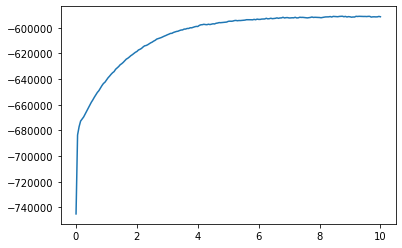

In [26]:
plt.plot(data['time'], data['potential'])

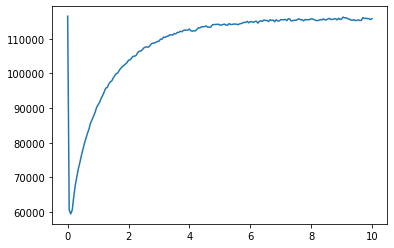

In [27]:
plt.plot(data['time'], data['kinetic'])

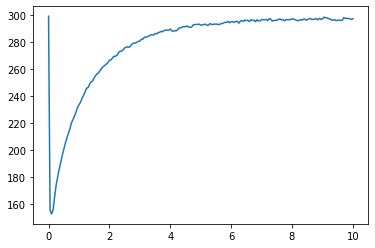

In [28]:
plt.plot(data['time'], data['kinetic_temperature'])

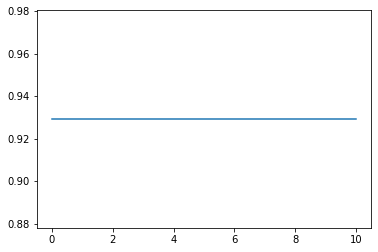

In [29]:
plt.plot(data['time'], data['density'])